In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import misc
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

%run 'DataImport.ipynb'

In [18]:
filepath = os.path.join('.','data')
datapath= filepath

In [19]:
data = DataSet(filepath,dataset_type='micro_2D', batch_size=32)

In [20]:
data.batch_size

32

In [21]:
data.num_batches

656

In [22]:
data.num_samples

21000

In [23]:
data.num_val_samples

9000

In [24]:
x_batch, y_batch = next(data.val_batches())

In [25]:
print(np.shape(y_batch))
y_back = []
for train in y_batch:
    y_back.append(train.argmax(1))

y_back = np.asarray(y_back)
y_back = y_back.reshape(x_batch.shape[0],x_batch.shape[1],x_batch.shape[2]) 
np.shape(y_back)

(32, 16384, 2)


(32, 128, 128)

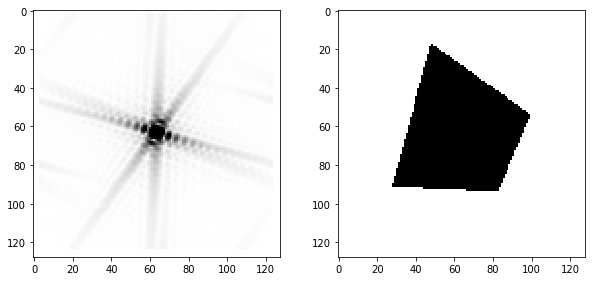

In [26]:
plt.figure(1,figsize=(10,10))
plt.subplot(221)
plt.imshow(x_batch[2].reshape(128,128), cmap='gist_gray')
plt.subplot(222, facecolor='y') 
plt.imshow(y_back[2].reshape(128,128), cmap='gist_gray')

### Create Model

In [146]:
from keras.layers import Input, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Concatenate, UpSampling2D
from keras.layers import Reshape, Activation, Permute
from keras.models import Model
from keras.optimizers import Adam, RMSprop
import keras

%run '../DeepUNet/DeepUNet.ipynb'
#from keras.optimizers import SGD

loaded!


In [147]:
input_height, input_width, nChannels = np.shape(x_batch)[1], np.shape(x_batch)[2], np.shape(x_batch)[3]

UNet = Nets().DeepUnet(nClasses=2, depth = 3, dropout_rate=0.2, optimizer=RMSprop(lr = 0.0001), 
                            input_width=input_width , input_height=input_height , nChannels=nChannels,
                            kernel_initializer='VarianceScaling'
                      )

UNet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_36 (InputLayer)            (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_445 (Conv2D)              (None, 128, 128, 64)  640         input_36[0][0]                   
____________________________________________________________________________________________________
conv2d_446 (Conv2D)              (None, 128, 128, 128) 73856       conv2d_445[0][0]                 
____________________________________________________________________________________________________
dropout_186 (Dropout)            (None, 128, 128, 128) 0           conv2d_446[0][0]                 
___________________________________________________________________________________________

In [140]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
file_path = './UNet.h5'

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

modl_checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0,
                                     save_best_only = True, mode = 'min', period = 2)

hist = LossHistory()

callbacks = [hist, modl_checkpoint] 

In [148]:
UNet.load_weights(file_path)

In [149]:
history = UNet.fit_generator(
    data.batches(), 
    steps_per_epoch = data.num_batches,                  # data.num_batches to train on full set 
    epochs = 4, 
    validation_data  = data.val_batches(), 
    validation_steps = data.num_val_batches,             # data.num_val_batches to validate on full set
    verbose = 1, callbacks=callbacks
)

Epoch 1/4
656/656 [==============================] - 466s - loss: 0.0564 - acc: 0.9731 - val_loss: 0.0588 - val_acc: 0.9721
Epoch 2/4
656/656 [==============================] - 482s - loss: 0.0558 - acc: 0.9734 - val_loss: 0.0585 - val_acc: 0.9722
Epoch 3/4
656/656 [==============================] - 480s - loss: 0.0555 - acc: 0.9735 - val_loss: 0.0582 - val_acc: 0.9722
Epoch 4/4
656/656 [==============================] - 479s - loss: 0.0554 - acc: 0.9735 - val_loss: 0.0580 - val_acc: 0.9723


<function matplotlib.pyplot.tight_layout>

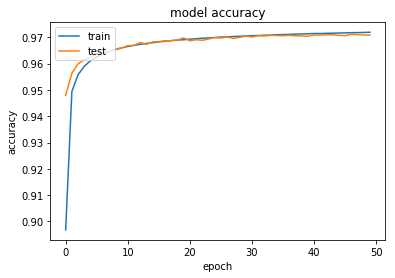

In [142]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

#labeling
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout

<function matplotlib.pyplot.tight_layout>

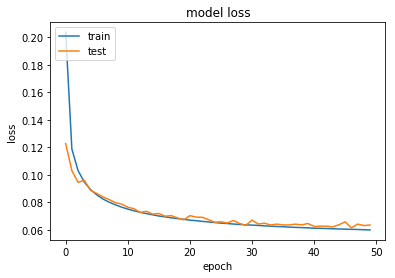

In [143]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#labeling
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout

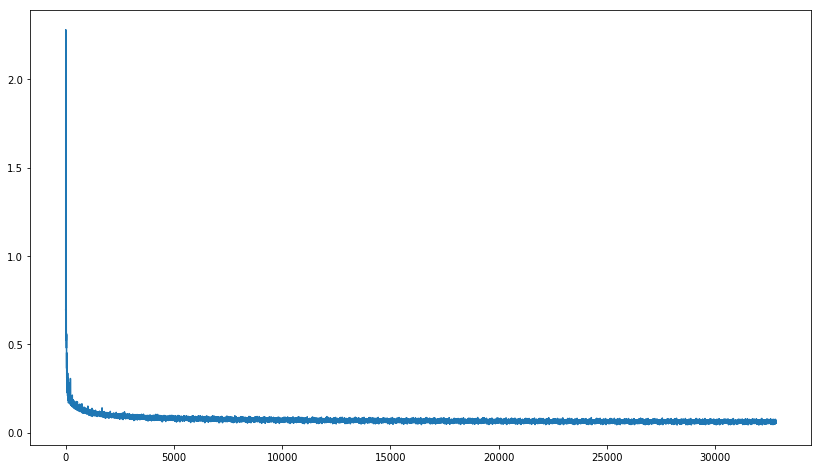

In [144]:
loss = hist.losses
Batches = range(len(loss)) 

fig = plt.figure(figsize=(14,8))
plt.plot(Batches, loss)
plt.show()

In [ ]:
train_eval = UNet.evaluate_generator(data.batches(), steps = data.num_batches)
evalu      = UNet.evaluate_generator(data.val_batches(),steps = data.num_val_batches)

print(train_eval)
print(evalu)

#### save model

In [150]:
# save model
benchmark_model_name = 'UNet.h5'
UNet.save(benchmark_model_name)

### Test Predictions

In [151]:
benchmark_model_name = 'UNet.h5'
# load model
from keras.models import load_model

UNet = load_model(benchmark_model_name)

In [161]:
x_batch, y_batch = next(data.val_batches())
y_prediction = UNet.predict_on_batch(x_batch)

UNet.test_on_batch(x_batch, y_batch)

[0.056047004, 0.97281075]

In [162]:
xx = DataSet(filepath,dataset_type='micro_2D', batch_size=32).reconstruct(y_batch)
yy = DataSet(filepath,dataset_type='micro_2D', batch_size=32).reconstruct(y_prediction)
#test_on_batch

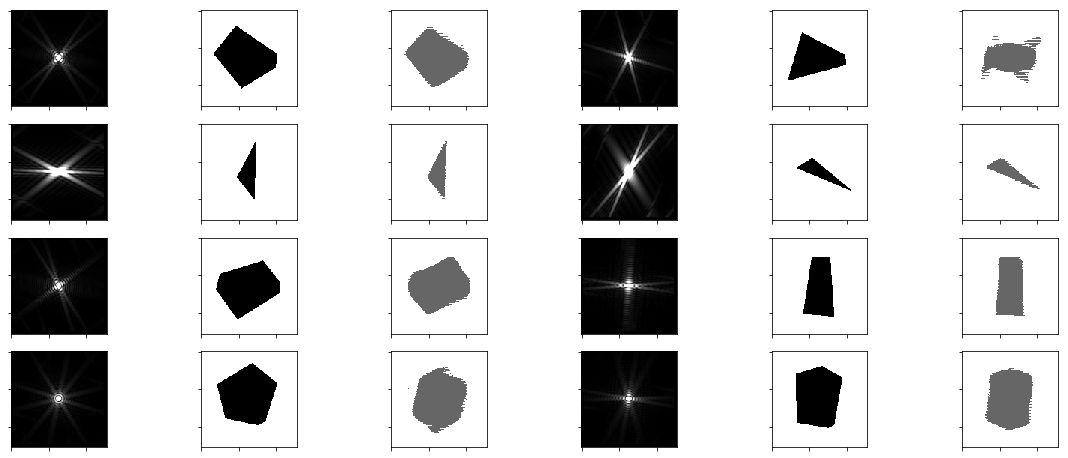

In [163]:
def ax_tick(ax1):
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    #ax1.set_aspect('equal')
    return None

#set picture size custom for paper
fig = plt.figure(1,figsize=(16,8))
max_num = 5
#gs1 = gridspec.GridSpec(max_num, 6)
#gs1.update(wspace=0.025, hspace=0.05)

for num in range(1,max_num):
    axs1 = plt.subplot2grid((max_num, 6), (num, 0) , rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((max_num, 6), (num, 1) , rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((max_num, 6), (num, 2) , rowspan=1, colspan=1)
    axs2 = plt.subplot2grid((max_num, 6), (num, 3) , rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((max_num, 6), (num, 4) , rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((max_num, 6), (num, 5) , rowspan=1, colspan=1)
    
    axs1.imshow(x_batch[num].reshape(128,128), cmap=plt.cm.gray_r)
    ax1.imshow(xx[num], cmap=plt.cm.gray)
    ax2.imshow(yy[num], cmap=plt.cm.gray, alpha=.6)
    axs2.imshow(x_batch[-num].reshape(128,128), cmap=plt.cm.gray_r)
    ax3.imshow(xx[-num], cmap=plt.cm.gray)
    ax4.imshow(yy[-num], cmap=plt.cm.gray, alpha=.6)
    
    ax_tick(axs1)
    ax_tick(axs2)
    ax_tick(ax1)
    ax_tick(ax2)
    ax_tick(ax3)
    ax_tick(ax4)
    

fig.subplots_adjust(wspace=0, hspace=0)

fig.tight_layout()
fig.savefig('results.pdf')
fig.show()